N=5000, N_train=3750, N_test=1250, L=4
  1. Lambda=0.00010, Gamma=0.00, N_estimators=150, Accuracy=0.9312
  2. Lambda=1.00000, Gamma=0.00, N_estimators=150, Accuracy=0.9312
  3. Lambda=0.00010, Gamma=0.00, N_estimators=400, Accuracy=0.9304
  4. Lambda=0.00100, Gamma=0.00, N_estimators=50, Accuracy=0.9304
  5. Lambda=1.00000, Gamma=0.00, N_estimators=200, Accuracy=0.9304
WORST
  Lambda=10.00000, Gamma=1.00, N_estimators=500, Accuracy=0.8696
 plot 1...
  Feature Importances: [0.433 0.433 0.065 0.068]


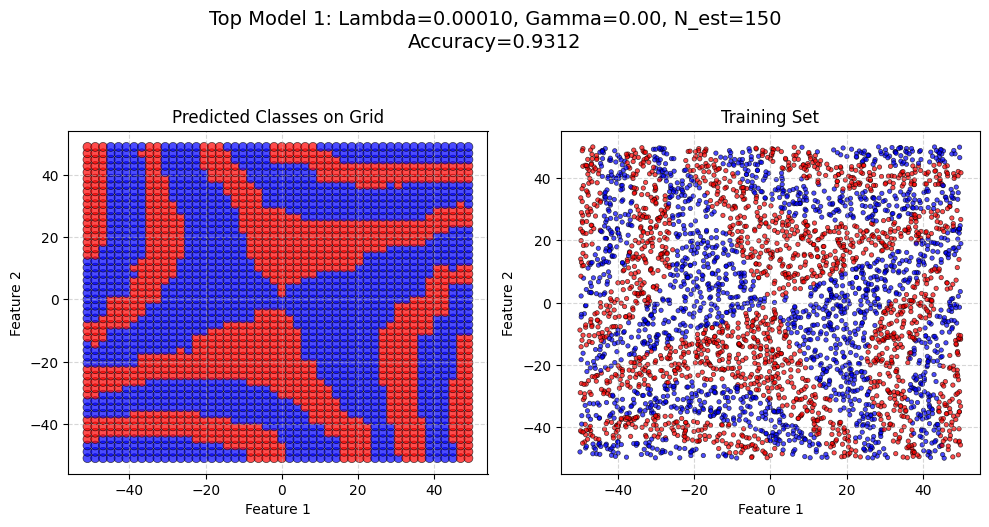

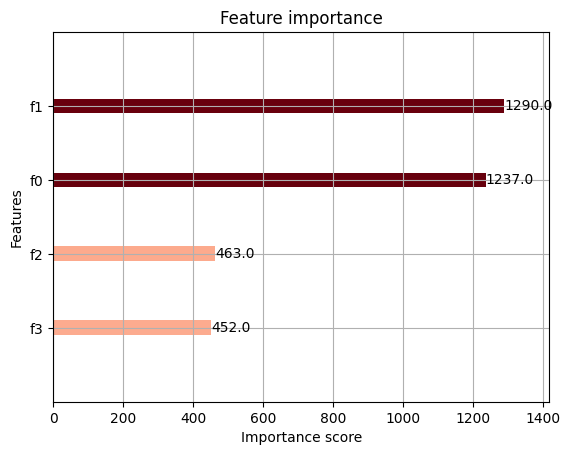

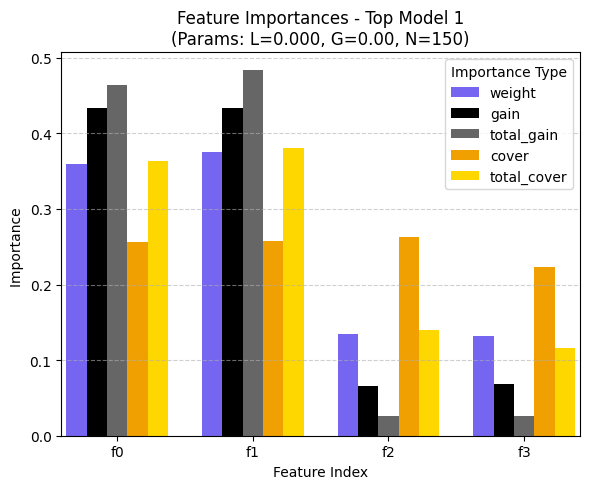

 plot 2...
  Feature Importances: [0.439 0.439 0.057 0.065]


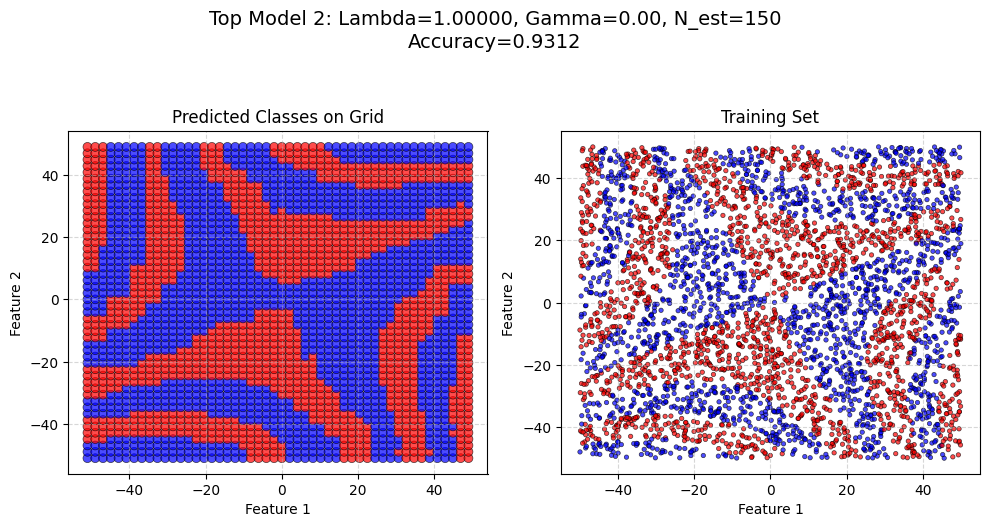

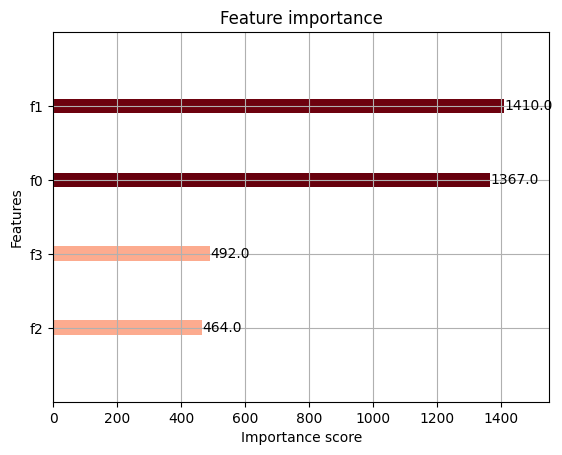

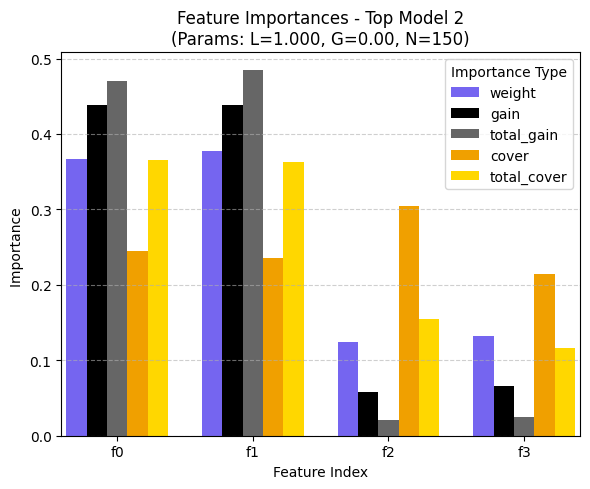

 plot 3...
  Feature Importances: [0.44  0.435 0.061 0.064]


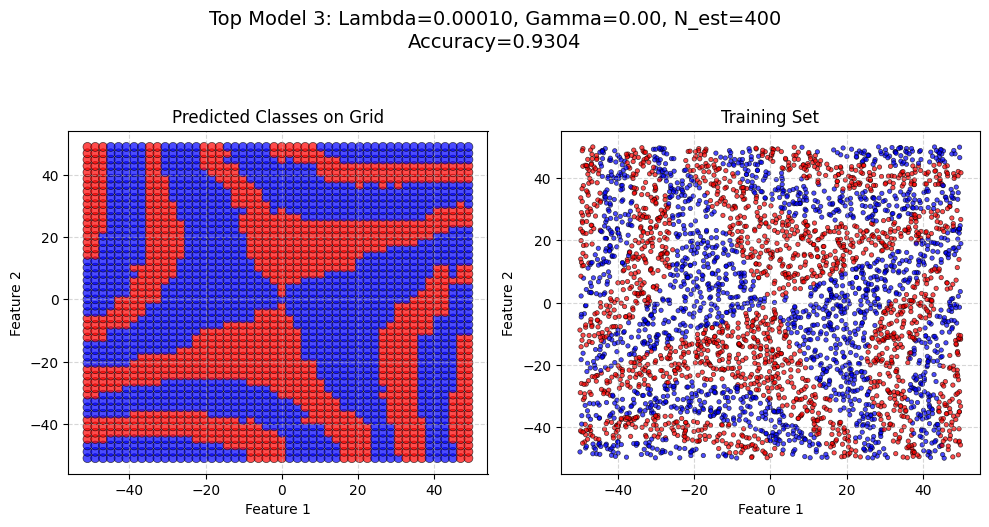

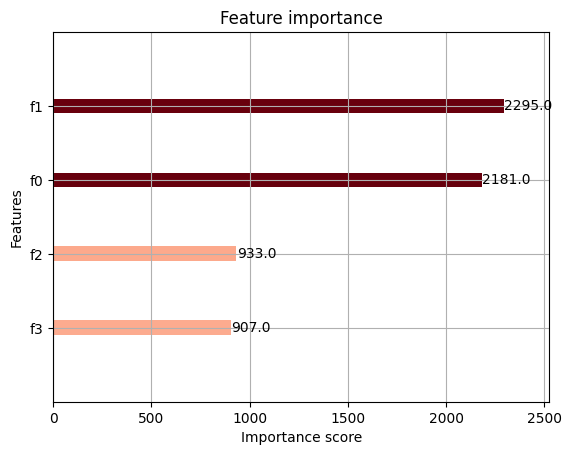

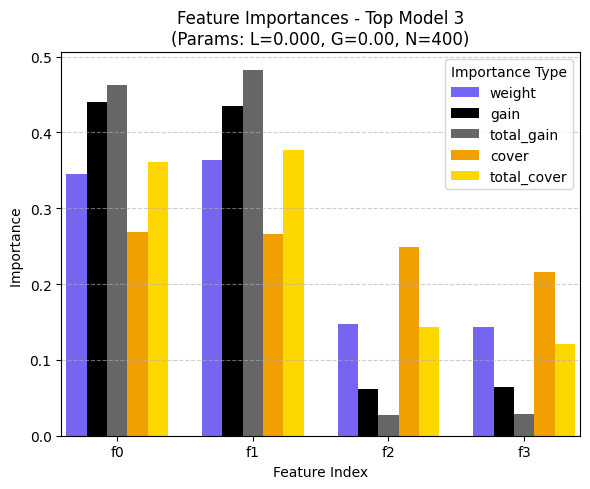

 plot 4...
  Feature Importances: [0.427 0.427 0.071 0.075]


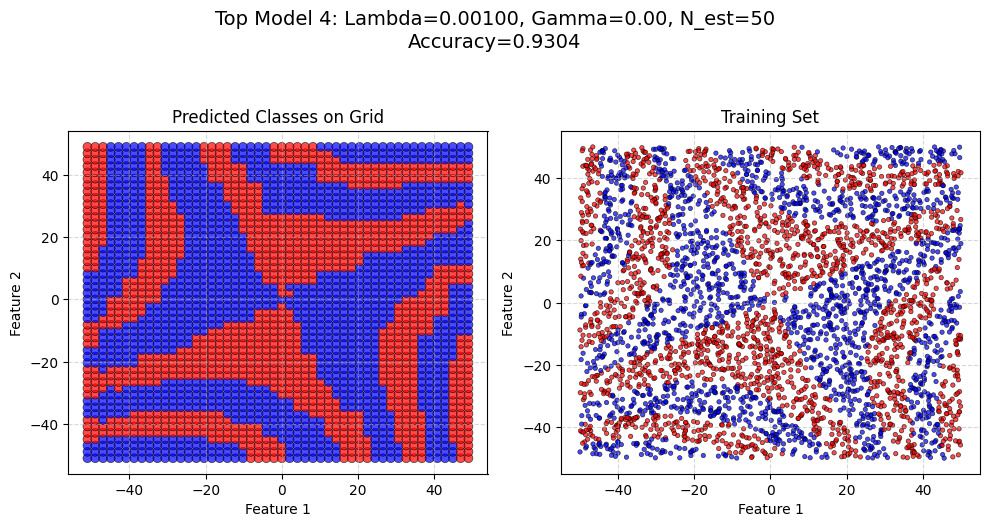

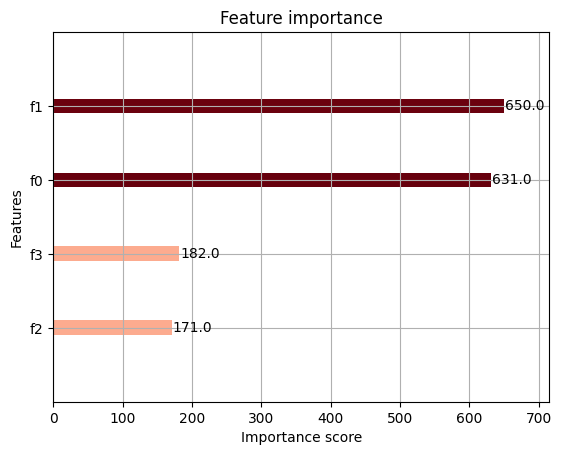

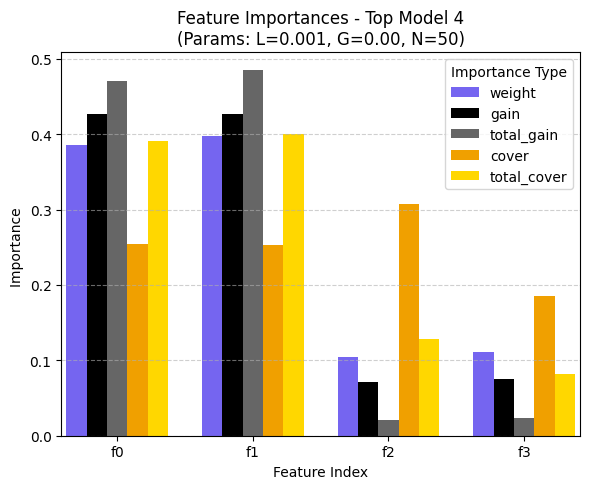

 plot 5...
  Feature Importances: [0.437 0.442 0.057 0.064]


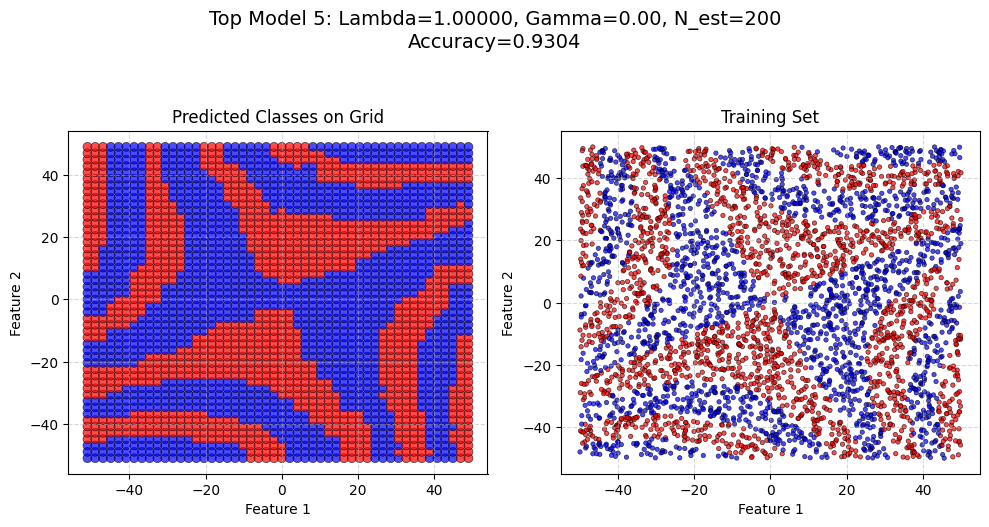

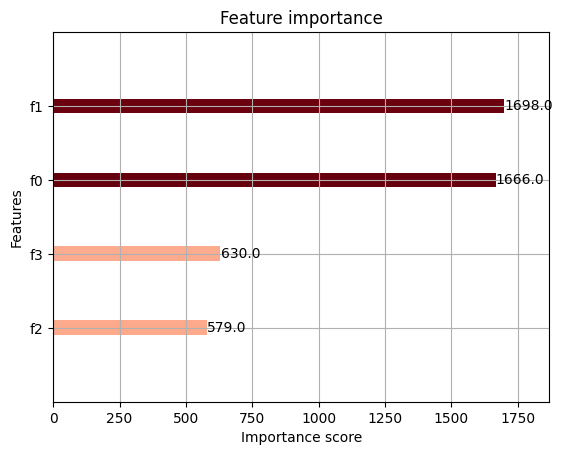

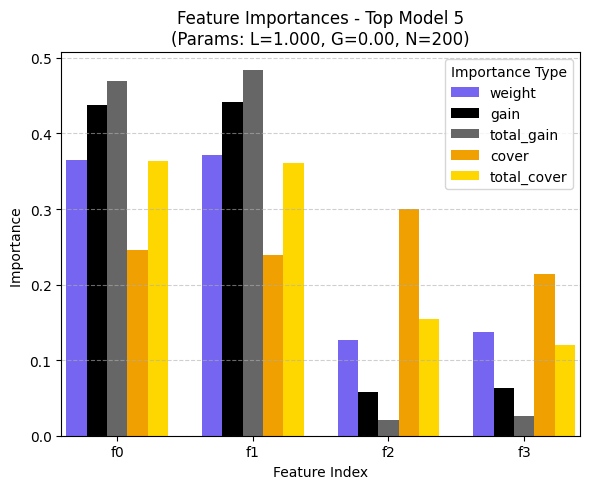

  Feature Importances: [0.428 0.428 0.07  0.074]


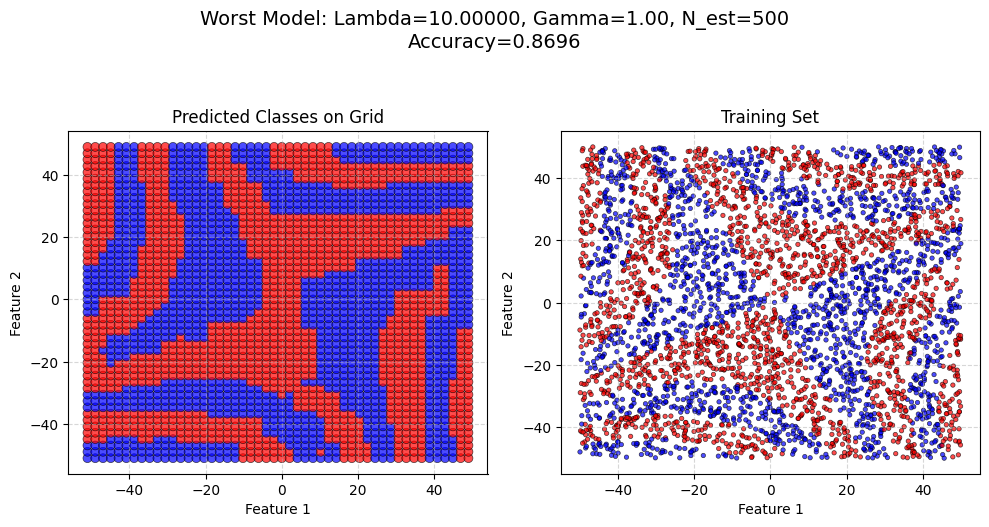

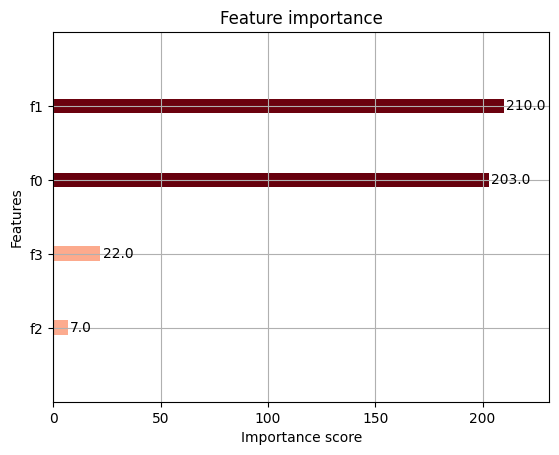

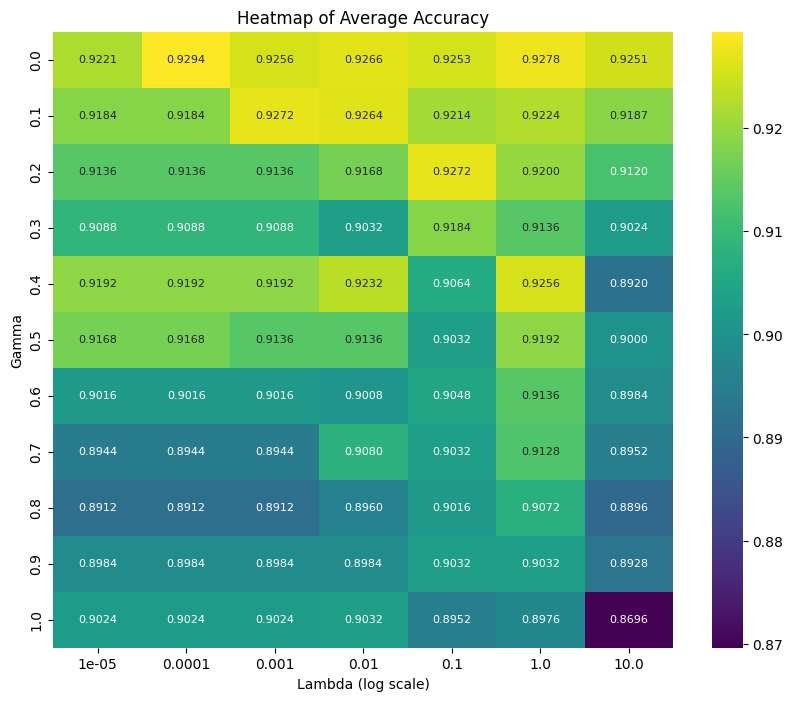

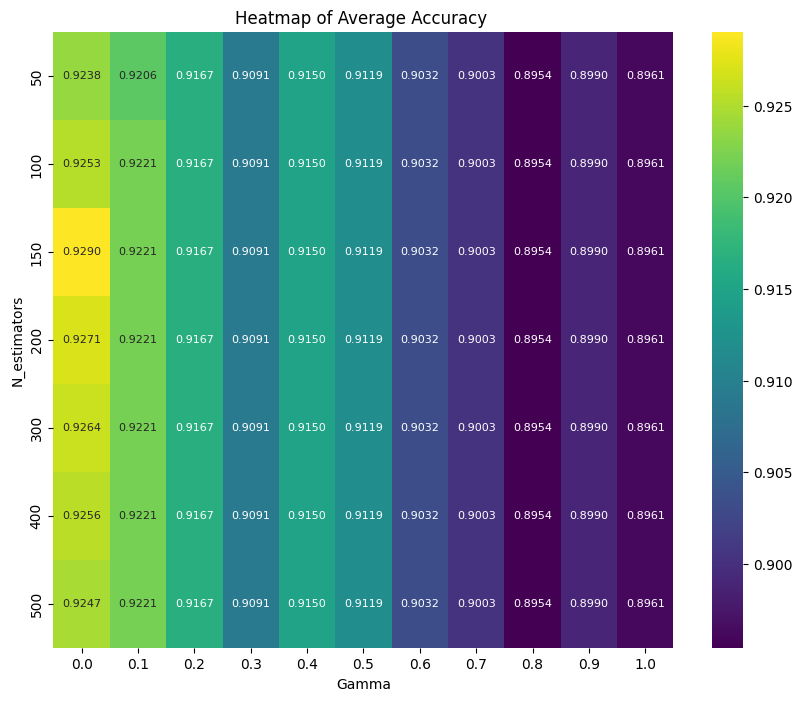

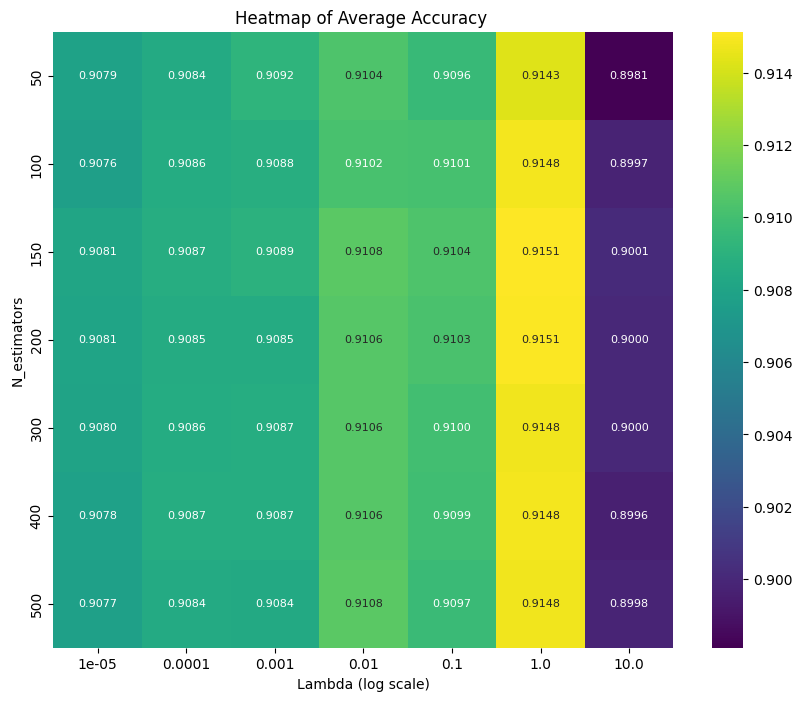

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score

def scat(ax, x_data, y_data, title="", s=10, alpha=0.7):
    if x_data.shape[1] < 2:
        ax.set_title(title)
        return
    colors = {0: 'blue', 1: 'red'} 
    ax.scatter(x_data[:, 0], x_data[:, 1],
               c=[colors.get(c, 'gray') for c in y_data],  
               s=s, alpha=alpha, edgecolors='k', linewidths=0.5)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

np.random.seed(12345)

dname = "./DATA/"
str0 = "_XGB_25.dat"
fnamex = dname + 'x' + str0
fnamey = dname + 'y' + str0

try:
    x = np.loadtxt(fnamex, delimiter=" ", dtype=float)
    y = np.loadtxt(fnamey)
except FileNotFoundError:
    print(f"  {fnamex}")
    print(f"  {fnamey}")
    exit()  
except Exception as e:
    exit()

y = y.astype(int)
N, L = x.shape

if L < 2:
    exit()

N_train = int(0.75 * N)
x_train, y_train = x[:N_train], y[:N_train]
x_test, y_test = x[N_train:], y[N_train:]
print(f"N={N}, N_train={N_train}, N_test={N - N_train}, L={L}")

lambda_vals = np.logspace(-5, 1, 7)
n_estimators_vals = [50, 100, 150, 200, 300, 400, 500]
gamma_vals = np.round(np.linspace(0, 1, 11), 2)

results = []
total_combinations = len(lambda_vals) * len(gamma_vals) * len(n_estimators_vals)
count = 0

for reg_lambda in lambda_vals:
    for gamma in gamma_vals:
        for n_estimators in n_estimators_vals:
            count += 1
            model_search = XGBClassifier(
                seed=1,
                objective='binary:logistic',
                importance_type="gain",
                learning_rate=0.4,
                reg_lambda=reg_lambda,
                gamma=gamma,
                n_estimators=n_estimators,
                eval_metric='logloss'
            )
            model_search.fit(x_train, y_train)
            y_pred = model_search.predict(x_test)
            accuracy = accuracy_score(y_test, y_pred)
            results.append((reg_lambda, gamma, n_estimators, accuracy))

sorted_results = sorted(results, key=lambda item: item[3], reverse=True)

top_5_models_params = sorted_results[:5] 

for i, (reg_lambda, gamma, n_estimators, accuracy) in enumerate(top_5_models_params):
    print(f"  {i+1}. Lambda={reg_lambda:.5f}, Gamma={gamma:.2f}, N_estimators={n_estimators}, Accuracy={accuracy:.4f}")

worst_params = sorted_results[-1]
worst_lambda, worst_gamma, worst_n_estimators, worst_accuracy = worst_params
print("WORST")
print(f"  Lambda={worst_lambda:.5f}, Gamma={worst_gamma:.2f}, N_estimators={worst_n_estimators}, Accuracy={worst_accuracy:.4f}")

margin = 1.0 
x0_min, x0_max = x_train[:, 0].min() - margin, x_train[:, 0].max() + margin
x1_min, x1_max = x_train[:, 1].min() - margin, x_train[:, 1].max() + margin
dx = max((x0_max - x0_min) / 50, 1e-6)  

x0_seq = np.arange(x0_min, x0_max, dx)
x1_seq = np.arange(x1_min, x1_max, dx)
nx0, nx1 = len(x0_seq), len(x1_seq)

x_plot = np.zeros((nx0 * nx1, L))
q = 0
for i in range(nx0):
    for j in range(nx1):
        x_plot[q, 0] = x0_seq[i]
        x_plot[q, 1] = x1_seq[j]
        q += 1

for i, (reg_lambda, gamma, n_estimators, accuracy) in enumerate(top_5_models_params):
    print(f" plot {i+1}...")
    best_model = XGBClassifier(
        seed=1, objective='binary:logistic', importance_type="gain", learning_rate=0.4,
        reg_lambda=reg_lambda, gamma=gamma, n_estimators=n_estimators,
        eval_metric='logloss'
    )
    best_model.fit(x_train, y_train)
    print(f"  Feature Importances: {np.round(best_model.feature_importances_, 3)}")
    y_plot = best_model.predict(x_plot)

    fig, AX = plt.subplots(1, 2, figsize=(10, 5.5))
    fig.suptitle(f"Top Model {i+1}: Lambda={reg_lambda:.5f}, Gamma={gamma:.2f}, N_est={n_estimators}\nAccuracy={accuracy:.4f}", fontsize=14)
    scat(AX[0], x_plot, y_plot, s=max(1, int(dx * dx * 10)), title=f"Predicted Classes on Grid")
    scat(AX[1], x_train, y_train, title="Training Set")
    fig.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

    my_cmap = plt.get_cmap("Reds")
    rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
    plot_importance(best_model, color=my_cmap(rescale_r(best_model.feature_importances_)))
    plt.show()
    fig_multi_imp, ax_multi_imp = plt.subplots(figsize=(6, 5)) 

    list_type = ["weight", "gain", "total_gain", "cover", "total_cover"]
    list_col = ["#7565F0", "k", "#666666", "#F0A000", "gold"]
    bar_width = 0.15 
    n_types = len(list_type)

    feature_indices = np.arange(L) 

    for k, imp_type in enumerate(list_type): 
        try:
            feature_imp_dict = best_model.get_booster().get_score(importance_type=imp_type)

            values = np.zeros(L)
            for f_key, score in feature_imp_dict.items():
                try:
                    f_index = int(f_key[1:])
                    if 0 <= f_index < L:
                        values[f_index] = score
                    else:
                         print(f"   {f_index} [0, {L-1}] '{imp_type}'.")
                except (ValueError, IndexError):
                    print(f"    Warning '{f_key}' o '{imp_type}'.")

            total_importance = np.sum(values)
            if total_importance > 1e-9:
                normalized_values = values / total_importance
            else:
                normalized_values = values 

 
            bar_positions = feature_indices + (k - n_types / 2.0 + 0.5) * bar_width

            ax_multi_imp.bar(bar_positions, normalized_values, width=bar_width, color=list_col[k % len(list_col)], label=imp_type)

        except Exception as e:
             print(f"    Errore '{imp_type}': {e}")

    ax_multi_imp.set_xlabel("Feature Index")
    ax_multi_imp.set_ylabel("Importance ")
    ax_multi_imp.set_title(f"Feature Importances - Top Model {i+1}\n(Params: L={reg_lambda:.3f}, G={gamma:.2f}, N={n_estimators})")
    ax_multi_imp.set_xticks(feature_indices) 
    ax_multi_imp.set_xticklabels([f'f{j}' for j in range(L)]) 
    ax_multi_imp.legend(title="Importance Type")
    ax_multi_imp.grid(axis='y', linestyle='--', alpha=0.6)
    ax_multi_imp.margins(x=0.01) 
    fig_multi_imp.tight_layout()
    plt.show()

worst_model = XGBClassifier(
    seed=1, objective='binary:logistic', importance_type="gain", learning_rate=0.4,
    reg_lambda=worst_lambda, gamma=worst_gamma, n_estimators=worst_n_estimators, eval_metric='logloss'
)
worst_model.fit(x_train, y_train)

print(f"  Feature Importances: {np.round(worst_model.feature_importances_, 3)}")

y_plot_worst = worst_model.predict(x_plot)

fig_worst, AX_worst = plt.subplots(1, 2, figsize=(10, 5.5))
fig_worst.suptitle(f"Worst Model: Lambda={worst_lambda:.5f}, Gamma={worst_gamma:.2f}, N_est={worst_n_estimators}\nAccuracy={worst_accuracy:.4f}", fontsize=14)

scat(AX_worst[0], x_plot, y_plot_worst, s=max(1, int(dx * dx * 10)), title=f"Predicted Classes on Grid")
scat(AX_worst[1], x_train, y_train, title="Training Set")  

fig_worst.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

my_cmap = plt.get_cmap("Reds")
rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(worst_model, color=my_cmap(rescale_r(worst_model.feature_importances_)))
plt.show()

results_array = np.array(results)

def get_avg_accuracy(param1_val, param1_idx, param2_val, param2_idx):
    subset = [r[3] for r in results if r[param1_idx] == param1_val and r[param2_idx] == param2_val]
    return np.mean(subset) if subset else 0

accuracy_grid_lambda_gamma = np.zeros((len(gamma_vals), len(lambda_vals)))
for i, lam in enumerate(lambda_vals):
    for j, gam in enumerate(gamma_vals):
        accuracy_grid_lambda_gamma[j, i] = get_avg_accuracy(lam, 0, gam, 1)

plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_grid_lambda_gamma, xticklabels=np.round(lambda_vals, 5), yticklabels=gamma_vals, cmap="viridis", annot=True, fmt=".4f", annot_kws={"size": 8})
plt.xlabel('Lambda (log scale)')
plt.ylabel('Gamma')
plt.title('Heatmap of Average Accuracy')
plt.show()

accuracy_grid_gamma_n_estimators = np.zeros((len(n_estimators_vals), len(gamma_vals)))
for i, gam in enumerate(gamma_vals):
    for j, n_estim in enumerate(n_estimators_vals):
        accuracy_grid_gamma_n_estimators[j, i] = get_avg_accuracy(gam, 1, n_estim, 2)

plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_grid_gamma_n_estimators, xticklabels=gamma_vals, yticklabels=n_estimators_vals, cmap="viridis", annot=True, fmt=".4f", annot_kws={"size": 8})
plt.xlabel('Gamma')
plt.ylabel('N_estimators')
plt.title('Heatmap of Average Accuracy ')
plt.show()

accuracy_grid_n_estimators_lambda = np.zeros((len(n_estimators_vals), len(lambda_vals)))
for i, lam in enumerate(lambda_vals):
    for j, n_estim in enumerate(n_estimators_vals):
        accuracy_grid_n_estimators_lambda[j, i] = get_avg_accuracy(lam, 0, n_estim, 2)

plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_grid_n_estimators_lambda, xticklabels=np.round(lambda_vals, 5), yticklabels=n_estimators_vals, cmap="viridis", annot=True, fmt=".4f", annot_kws={"size": 8})
plt.xlabel('Lambda (log scale)')
plt.ylabel('N_estimators')
plt.title('Heatmap of Average Accuracy ')
plt.show()

### In the code above we performed XGB with different values of Lambda, Gamma and N_estimators. From the heatmap we can clearly see that the performance worsenes as Gamma grows, in fact the 5 best models obtained have all gamma = 0, leading us to belive that the simpler model where gamma is taken into account as 0 performs the best.

### Likewise from the 2nd and 3rd heatmap we can appreciate how N_estimators didn't have a big impact on the overall model, we thus conclude that the main parameter to be optimize is lambda

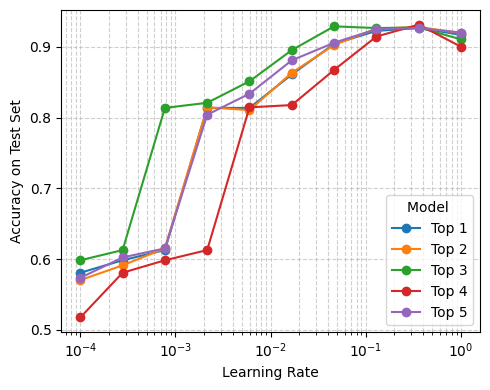

In [8]:

learning_rates_to_test = np.logspace(-4, 0, 10) 

learning_rate_results = {}

for i, (reg_lambda, gamma, n_estimators, _) in enumerate(top_5_models_params):
    accuracies_vs_lr = [] 

    for lr in learning_rates_to_test:
        model_lr_test = XGBClassifier(
            seed=1,                   
            objective='binary:logistic',
            importance_type="gain",
            learning_rate=lr,          
            reg_lambda=reg_lambda,     
            gamma=gamma,                
            n_estimators=n_estimators,  
            eval_metric='logloss'      
        )

        model_lr_test.fit(x_train, y_train)

        y_pred_lr = model_lr_test.predict(x_test)

        accuracy_lr = accuracy_score(y_test, y_pred_lr)
        accuracies_vs_lr.append((lr, accuracy_lr))

    learning_rate_results[i] = accuracies_vs_lr

plt.figure(figsize=(5, 4))

for i, results_list in learning_rate_results.items():
    lrs = [item[0] for item in results_list]
    accs = [item[1] for item in results_list]

    orig_lambda, orig_gamma, orig_n_est, orig_acc = top_5_models_params[i]
    label = (f"Top {i+1}") 

    plt.plot(lrs, accs, marker='o', linestyle='-', label=label)

plt.xscale('log')  
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy on Test Set")
plt.legend(fontsize=10, title="Model ")
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## We trained the best performing model on different values of learning rate, achieving poor performances for lr < 0.01  
## We can also see a clear tendency of the models to perform better with the increasing of lr, however this effect decreases at lr = 1